## MIMO - Three benefits of multiple antenna communications 
### Spatial multiplexing gains



### Method

For the simulation of the Spatial Multiplexing Gains I decided simulate the received power gain at three three users.

First of all the goal is to be able to focus the transmissions in three directions at the same time and frequency.

So different from the singular beam forming where only a singular receiver can be reached at a time. 

For simplicity and because of the short scope of the project I decided to go with linear array antenna simulation.


Starting by defining a Class called MIMOConfig, that is initialized with a number of antennas and an array of the angels the receivers are situated at. 

Furthermore all the simulations are executed with the frequency 3Ghz, there fore its a global constant. 
The number of antennas used for each beamforming is evenly divided amongst the receivers.

The antenna spacing (d) is half a wavelength, that is derived from the frequency
$$
\lambda  =\dfrac{\textit{c}}{\textit{f}}
$$

$$
d = \dfrac{\lambda}{2}
$$



For each of the receiver angles we generate a Array response, and then compute the superposition of said Arrays 

### Simulation setup 

In the simulation a separate channel to each receiver is represented by $a\left(\varphi\right)$ an array response steered towards the receiver’s position given by its angle $\varphi$ from the antenna arrays perspective. 

$$
a(\varphi) = w_{n,\varphi}^{\intercal} \cdot x_{n,\theta}
$$

Where $a\left(\varphi\right)$ is the array response with steering towards a specific angle $\varphi$ is obtained by combining the array response matrix $x_{n,\theta}$ with the weighted steering vector $w_{n,\varphi}$ calculated for a specific angle $\varphi$. The array response matrix $x_{n,\theta}$ is calculated from formula 2. And the weighted steering vector $w_{n,\varphi}$ pointed towards desired angle $\varphi$ is given by formula 3.

$$
x_{n,\theta} = \exp\left(-j \frac{2\pi(n - 1)d }{\lambda}\cos(\theta)\right)
$$

Where $\theta$ is an array comprised of all angles from $0$ to $2\pi$ given by  $\theta = \sum_{i=0}^{359}{i\pi / 180}$ and the indexing array of the antennas $n = \{1, 2, 3, \ldots, M\}$ for the number of antennas used $M$.

$$
w_{n,\varphi} = \exp\left(j \frac{2\pi(n - 1)d }{\lambda}\cos(\varphi)\right)
$$

For the formulas above the distance between the antennas $d\ = \lambda/2$  is half of the wavelength $\lambda =c/f$  and both have been derived from the frequency used $f$ and the constant $c$ which stands for the speed of light.

For visualization of each configuration with $k$ receivers, utilizing the equally weighted superposition $Sp$ of all the receivers weighted array responses for a polar plot showing an estimated signal propagation of the configuration.
given by 

$$
Sp = \sum_{i=1}^{k} \dfrac{a(\varphi_i)}{k}
$$ 


_________________________




$$
\begin{align*}
& n \text{ is the array index} \\
& \theta \text{ is the array of angles from } 0 \text{ to } 2\pi \\
& \phi \text{ is the angle of the receiver position}\\
& d \text{ is the antenna spacing} \\
& \lambda \text{ is the wavelength of the signal}
\end{align*}
$$

Then the superposition function then iterates over each array, and for each array, it adds the weighted contribution to results array 


$$
weights = \frac{1}{\text{num\_arrays}} \cdot \mathbf{1}
$$

or another way to put it where n stands for the number of arrays 

$$
\text{Superposition of array responses} = \frac{1}{n} \cdot (\text{Array}_1 + \text{Array}_2 + \ldots + \text{Array}_n)
$$

Then to get the Array Response of a specific angle is simple since the superposition array can simply by indexed by the angle in degrees, since theta is 360 values, and therefore indexes the array 
$$
\text{array\_response\_at\_angle} = \left| \text{Superposition Array}[\phi_{deg}] \right|
$$

Finally calculate the gain in dBi
$$
G_t (\text{dBi}) = 10 \cdot \log_{10}(\text{ArrayResponseAtAngle})
$$


## Initilazation code
Where the config is generated 

In [101]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import BoundaryNorm

# Constants used
SPEED_OF_LIGHT  = 3e8
FREQUENCY       = 3e9 # 3GHz
THETA           = np.arange(0, 2 * np.pi, np.pi / 180) #Theta values from 0 to 2*pi

class MIMOConfig:
    def __init__(self, num_antennas, receiver_angles_deg):

        # Number of receivers determined from the number of angles 
        self.num_receivers = len(receiver_angles_deg)

        # self.num_antennas = num_antennas // self.num_receivers - this is not correct
        self.num_antennas = num_antennas

        self.receiver_angles_deg = receiver_angles_deg
        self.receiver_angles_rad = [
            angle*(np.pi/180) for angle in receiver_angles_deg
        ]    
        
        # Calculate antenna spacing ( wavelength/2 ) (C/F)/2
        self.wavelength = SPEED_OF_LIGHT / FREQUENCY
        self.antenna_spacing = self.wavelength / 2
        
        self.array_responses = [
            self.getArrayResponse(angle_rad) for angle_rad in self.receiver_angles_rad
        ]

    def getArrayResponse(self, angle_rad):

        # Array indices
        n = np.arange(1,self.num_antennas + 1)
       
        # Reshape n to a column vector
        n = n.reshape(-1, 1)

        # Array response matrix
        X = np.exp(-1j * (n - 1) * 2 * np.pi * self.antenna_spacing * np.cos(THETA) / self.wavelength)
       
        # Weight vector for steering
        w = np.exp(1j * (n - 1) * 2 * np.pi * self.antenna_spacing * np.cos(angle_rad) / self.wavelength)
        w = w.reshape(-1, 1)
        # Array response with steering
        #self.array_responses = np.dot(w.T, X)
        return np.dot(w.T, X)

### Helper functions 

Calculate the superposition of the arrays 
And from that calculate the angularGain in dBi

In [102]:
def angularGainInDBi(superpossition, angle_deg):
        
        # The number of THETA's used = 360 - one per deg (so angle_deg can be the index)
        array_response_at_angle = np.abs(superpossition[0][angle_deg])

        # Calculate the gain of the transmitting antenna based on the array response
        Gt_dB = 10 * np.log10(array_response_at_angle)

        return Gt_dB


# Calculate the superposition of array_responses 
def superpose(arrays):
    num_arrays = len(arrays)
    weights = np.ones(num_arrays) / num_arrays  # Even weights
    result = np.zeros_like(arrays[0])
    for i in range(num_arrays):
        result += weights[i] * arrays[i]
    return result

def polarPlot(array, title):
    plt.figure(figsize=(7, 7))
    plt.polar(THETA, np.abs(array.flatten()), 'b')
    plt.gca().set_yticklabels([])
    plt.title(title)
    #plt.legend()
    plt.show()

Now we can show a simple setting - and visualize the scenario at hand

First lets look at a simple beamforming 

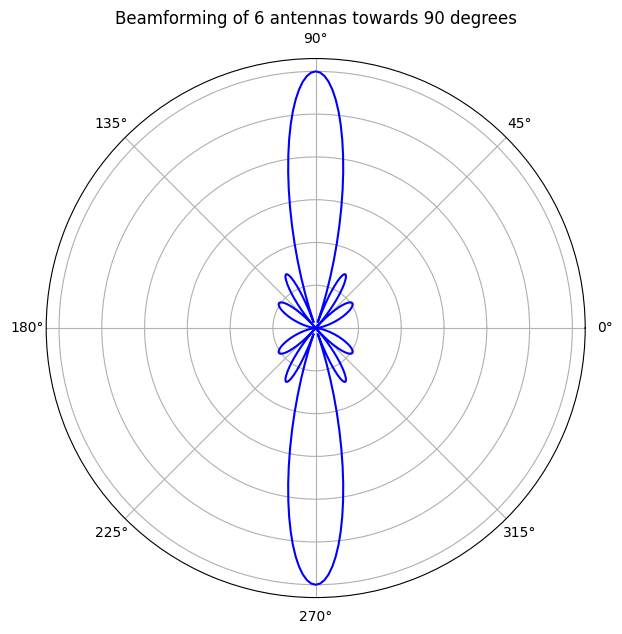

In [103]:

beamformingConfig = MIMOConfig(num_antennas=6, receiver_angles_deg=[90])
sp_beamforming = superpose(beamformingConfig.array_responses)
polarPlot(sp_beamforming , "Beamforming of 6 antennas towards 90 degrees")

Then look at a simple Spatial Multiplexing case

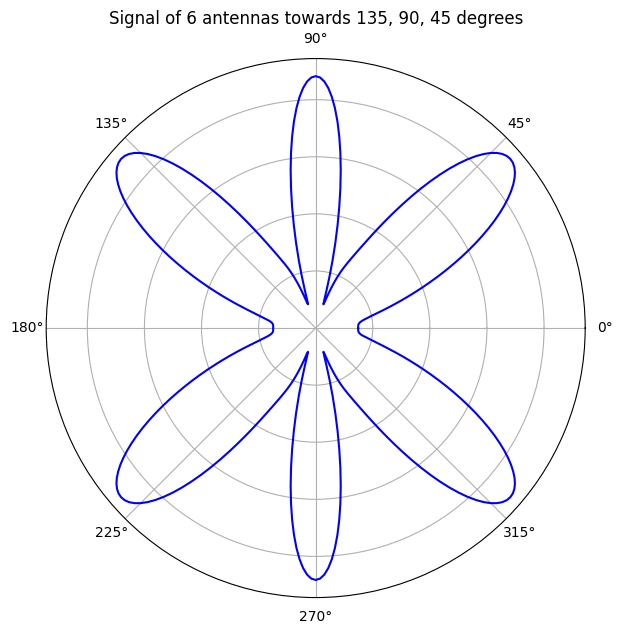

In [104]:
config1 = MIMOConfig(num_antennas=6, receiver_angles_deg=[135,90,45])
sp = superpose(config1.array_responses)
polarPlot(sp, 'Signal of 6 antennas towards 135, 90, 45 degrees')

However there needs to be sufficient space, or in our case ange between the recievers
Or we cant tell the transmissions apart 

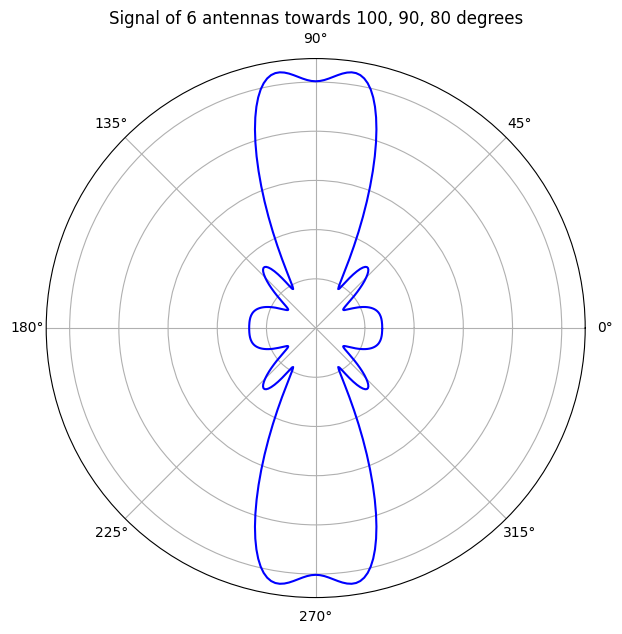

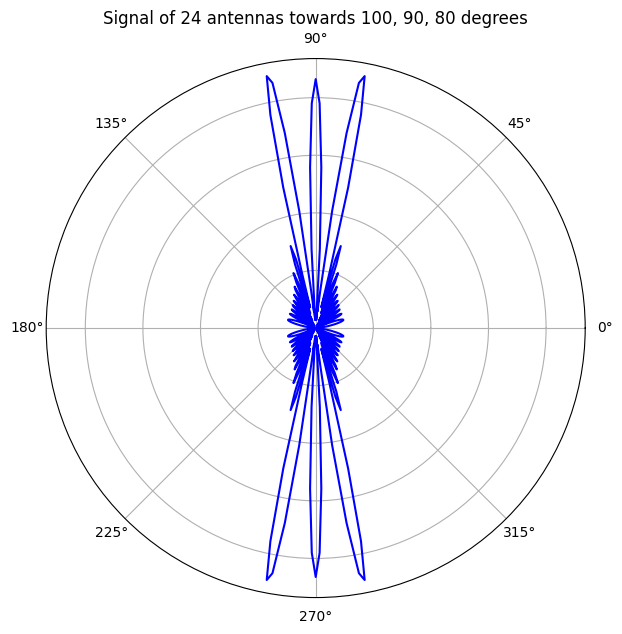

In [105]:
config2 = MIMOConfig(num_antennas=6, receiver_angles_deg=[100,90,80])
sp2 = superpose(config2.array_responses)
polarPlot(sp2, 'Signal of 6 antennas towards 100, 90, 80 degrees')

config2 = MIMOConfig(num_antennas=24, receiver_angles_deg=[100,90,80])
sp2 = superpose(config2.array_responses)
polarPlot(sp2, 'Signal of 24 antennas towards 100, 90, 80 degrees')

The optimal separation angle for 3 users would be what ? Equal separation ? 
How can it be effected ? 
- Number of antennas + the offset angle 

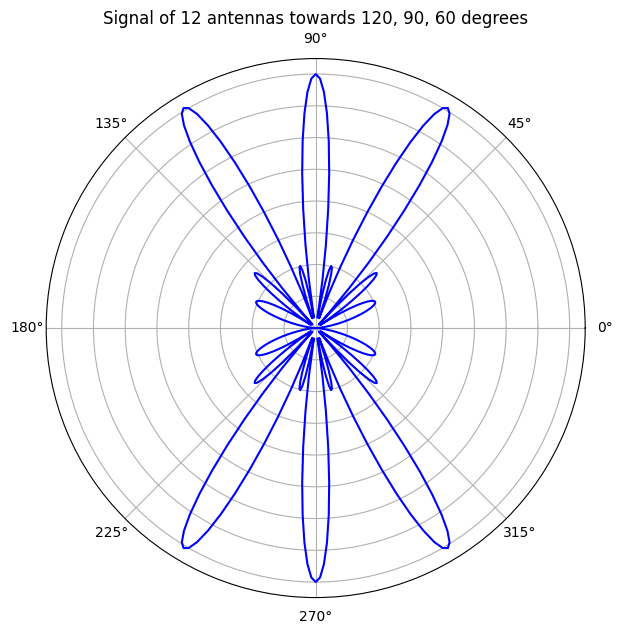

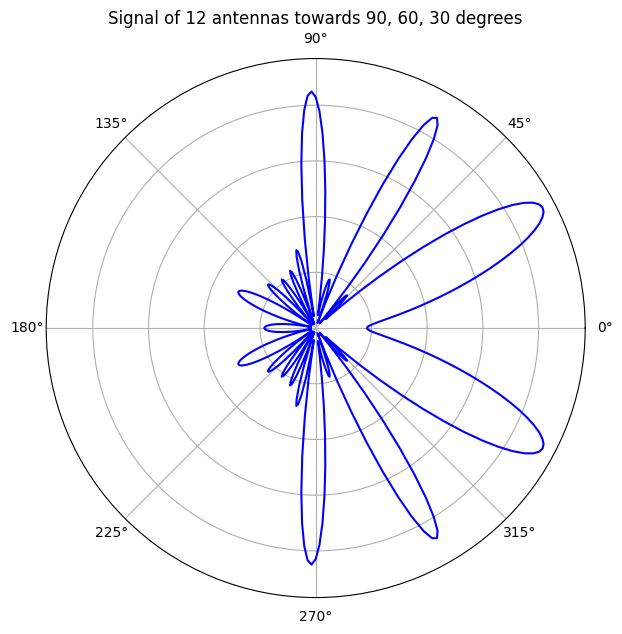

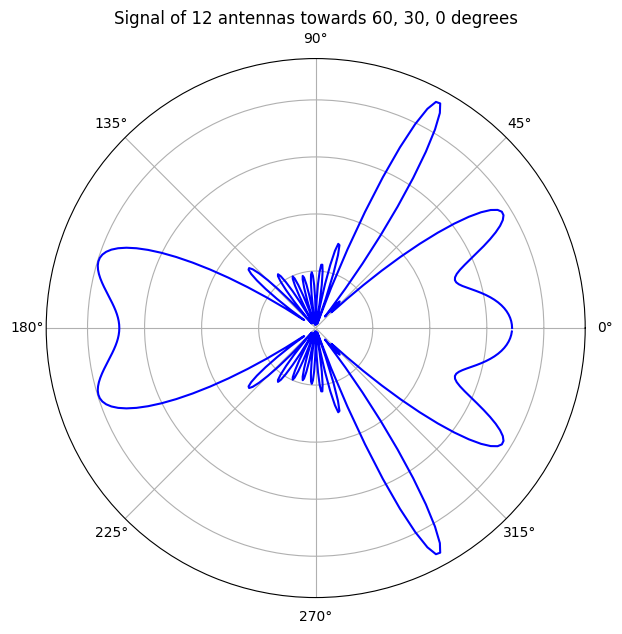

In [106]:
config2a = MIMOConfig(num_antennas=12, receiver_angles_deg=[120,90,60])
config2b = MIMOConfig(num_antennas=12, receiver_angles_deg=[90,60,30])
config2c = MIMOConfig(num_antennas=12, receiver_angles_deg=[60,30,0])

sp2a = superpose(config2a.array_responses)
polarPlot(sp2a, 'Signal of 12 antennas towards 120, 90, 60 degrees')

sp2b = superpose(config2b.array_responses)
polarPlot(sp2b, 'Signal of 12 antennas towards 90, 60, 30 degrees')

sp2c = superpose(config2c.array_responses)
polarPlot(sp2c, 'Signal of 12 antennas towards 60, 30, 0 degrees')

#config2a = MIMOConfig(num_antennas=24, receiver_angles_deg=[90,60,30])
#config2b = MIMOConfig(num_antennas=24, receiver_angles_deg=[60,30,0])

#sp2a = superpose(config2a.array_responses)
#polarPlot(sp2a)

#sp2b = superpose(config2b.array_responses)
#polarPlot(sp2b)

### Evaluation

Kindly provided by professor Emil.

To evaluate the received signal, the strength of it and the effects of a spatial multiplexing we need to be able to calculate the received signal. For a channel $h_{k} = a( \varphi_{k})$ to a user $k$ represented by an array response with steering towards the desired angle $\varphi_{k}$. Since we have $k$ users and the signals are transmitted using maximum ratio transmissions where directed towards $h_{k}^{\ast } / \| h_{k}\|$.

The transmitted signal $S_t$ is calculated from formula ATH!.

$$ S_{t} = \sum ^{k}_{i=1}\dfrac{h_i^{\ast }}{\| h_{i}\| }\cdot S_i = \sum ^{k}_{i=1}\dfrac{a^{\ast }(\varphi_{i}) }{\sqrt{M}} \cdot S_{i}
$$
Where $S_{i}$ is the signal with power $P_i$ for user $i$, and like before $M$ is the number of antennas in the configuration. Further more the power is equally distributed amongst all $M$ antennas. The received signal $S_r$ can then be derived from the transmitted signal in formula ATH!.
$$ 
S_{r}=h_{k}^\mathsf{T}S_t+n_{k} \\
= a^\mathsf{T} ( \varphi _{k}) \dfrac{a^{\ast } ( \varphi _{k}) }{\sqrt{M}}S_{k} 
+ \sum ^{k}_{i=1, i \neq k} a^\mathsf{T} ( \varphi _{k}) \dfrac{a^{\ast } ( \varphi _{i}) }{\sqrt{M}}S_{i} + n_{k}
$$
Essentially a summation of the desired signal, the signal intended for user $k$. 
The interference of other signals received but not intended for the user $k \neq i$ and the noise where $n_{k} = \sigma^{2}$ 

However, for a good estimation of the quality of the received signal we utilize the metric signal-to-interference-and-noise-ratio SINR. Since the addition of the interference to the more traditional signal-to-noise-ratio SNR is highly important in most spatial multiplexing scenarios, since the interference does play a major role. Allowing for the assessment of the systems ability to transmit multiple signals simultaneously and verifying successful multiplexing. Formula ATH! gives the calculation for $SINR_k$ for the SINR of a signal towards a user $k$.
$$ 
SINR_k = \dfrac{ \left| a^\mathsf{T} ( \varphi _{k}) \dfrac{a^{\ast } ( \varphi _{k}) }{\sqrt{M}}  \right|^{2} P_k } 
{ \left| \sum ^{k}_{i=1, i \neq k} a^\mathsf{T} ( \varphi _{k}) \dfrac{a^{\ast } ( \varphi _{i}) }{\sqrt{M}}   \right|^{2} P_i + n_{k} } 
\\
= \dfrac{ \dfrac{P_k}{M}  \left| a^\mathsf{T} ( \varphi _{k}) a^{\ast } ( \varphi _{k}) \right|^{2}  } 
{ \sum ^{k}_{i=1, i \neq k} \dfrac{P_i}{M} \left|  a^\mathsf{T} ( \varphi _{k}) a^{\ast } ( \varphi _{i})   \right|^{2} + \sigma^{2} } 
$$
Where $P_k$ and $P_i$ is the power of signals towards users $k$ and $i$ respectfully. Furthermore, the noise again is given by $n_{k} = \sigma^{2}$. The final ratio is like the name tells use the ratio between the desired signal of the channel $a(\varphi_k)$ towards user $k$ compared to the interference of the channels to the other users $k \neq i$ and the noise $n_{k}$.

In addition to the SINR of the system the Shannon capacity of the signal can then be derived from the SINR. With formula ATH! , giving us the maximum theoretical transfer rate over the channel.    
$$
\log _{2} ( 1+SINR_{k} ) _{bit/s/Hz}
$$




$SINR_k$ the signal-to-interference-and-noise ratio is then calculated from the array responses, where the ratio between the signal of the desired channel for user $k$ at angle $\varphi _{k}$ and the sum of other channels where $i \neq k$ as interference plus the noise $n_{k}$ given by formula ATH!.

$$ 
SINR_k = \dfrac{ \left| a^\mathsf{T} ( \varphi _{k}) \dfrac{a^{\ast } ( \varphi _{k}) }{\sqrt{M}}  \right|^{2} P_k } 
{ \left| \sum ^{k}_{i=1, i \neq k} a^\mathsf{T} ( \varphi _{k}) \dfrac{a^{\ast } ( \varphi _{i}) }{\sqrt{M}}   \right|^{2} P_i + n_{k} } 
\\
= \dfrac{ \dfrac{P_k}{M}  \left| a^\mathsf{T} ( \varphi _{k}) a^{\ast } ( \varphi _{k}) \right|^{2}  } 
{ \sum ^{k}_{i=1, i \neq k} \dfrac{P_i}{M} \left|  a^\mathsf{T} ( \varphi _{k}) a^{\ast } ( \varphi _{i})   \right|^{2} + \sigma^{2} } 
$$

$$ SINR_k
= \dfrac{ \dfrac{P_k}{M}  \left| a^\mathsf{T} ( \varphi _{k}) a^{\ast } ( \varphi _{k}) \right|^{2}  } 
{ \sum ^{k}_{i=1, i \neq k} \dfrac{P_i}{M} \left|  a^\mathsf{T} ( \varphi _{k}) a^{\ast } ( \varphi _{i})   \right|^{2} + \sigma^{2} } 
$$



In [107]:
def received_signal(config, user_angle_index, total_power, noise_power_dB):
    K = len(config.array_responses)  # Number of users
    M = config.num_antennas  # Number of antennas
    angle = config.receiver_angles_deg[user_angle_index]
    #signal_power = total_power / M
    signal_power = total_power 

    # Extract array response and signal power for the user of interest
    array_response_k = config.array_responses[user_angle_index]

    # Calculate the first term of the received signal equation (desired signal)
    desired_signal = np.abs(np.dot(array_response_k.conj().T, array_response_k) * (signal_power / np.sqrt(M)))

    desired_signal_sinr = np.abs(np.dot(array_response_k.conj().T, array_response_k))**2 * (total_power / M)

    # Calculate the interference factor (sum of all other users interference)
    interference, interference_sinr = 0, 0
    for i in range(K):
        if i != user_angle_index:
            interference += np.abs(np.dot(array_response_k.T, config.array_responses[i].conj()) * (signal_power / np.sqrt(M)))
            interference_sinr += np.abs(np.dot(array_response_k.conj().T, config.array_responses[i]))**2 * (total_power / M)

    # Linear 
    desiredSignal_linear = desired_signal[angle][angle]
    interference_linear = interference[angle][angle]
    noise_power_linear = 10 ** (noise_power_dB / 10)

    received_signal_linear = desiredSignal_linear - interference_linear - noise_power_linear
    #Avoid log10 (negative)
    if received_signal_linear < 0:
        received_signal_linear = 0

    # Calculate SINR
    sinr = desired_signal_sinr / (interference_sinr + noise_power_linear)
    sinr_linear = sinr[angle][angle]

    # Convert to dB
    desiredSignal_dB = 10 * np.log10(desiredSignal_linear)
    interference_dB = 10 * np.log10(interference_linear)
    received_signal_dB = 10 * np.log10(received_signal_linear) 
    sinr_dB = 10 * np.log10(sinr_linear)

    shannon = np.log2(1+sinr_linear)

    # Construct results dictionary
    results = {
        "Angle": angle,
        "Signal_Power_dB": desiredSignal_dB,
        "Interference_Power_dB": interference_dB,
        "Noise_Power_dB": noise_power_dB,
        "Received_signal_dB": received_signal_dB,
        "SINR_dB": sinr_dB,
        "shannon": shannon,
        "Recived_signal_array_dB": 10 * np.log10(desired_signal) - 10 * np.log10(interference) + noise_power_dB,
        "SINR_array_dB": 10 * np.log10(sinr)
    }

    return results

In [108]:
################################################################################################
#                                       DATA COLLECTION                                        #
################################################################################################

def iterateOverAnglesAndAntennas(separation_angles, antenna_counts, offset_angle=0):
    TRANSMIT_POWER = 0.1   # in W
    NOISE_POWER = -80   	# in dBm

    data = {"Antennas": [], "Separation_Angle": [], "Receiver1": [], "Receiver2": [], "Receiver3": []}
    for num_antennas in antenna_counts:
        for separation in separation_angles:
            centered_reciver_angle = 90-offset_angle

            config = MIMOConfig(num_antennas=num_antennas, receiver_angles_deg=[centered_reciver_angle+separation , centered_reciver_angle, centered_reciver_angle-separation])
            
            data["Antennas"].append(num_antennas)
            data["Separation_Angle"].append(separation)
            data["Receiver1"].append(received_signal(config, 0, TRANSMIT_POWER, NOISE_POWER).get("SINR_dB"))
            data["Receiver2"].append(received_signal(config, 1, TRANSMIT_POWER, NOISE_POWER).get("SINR_dB"))
            data["Receiver3"].append(received_signal(config, 2, TRANSMIT_POWER, NOISE_POWER).get("SINR_dB"))
               
    return data

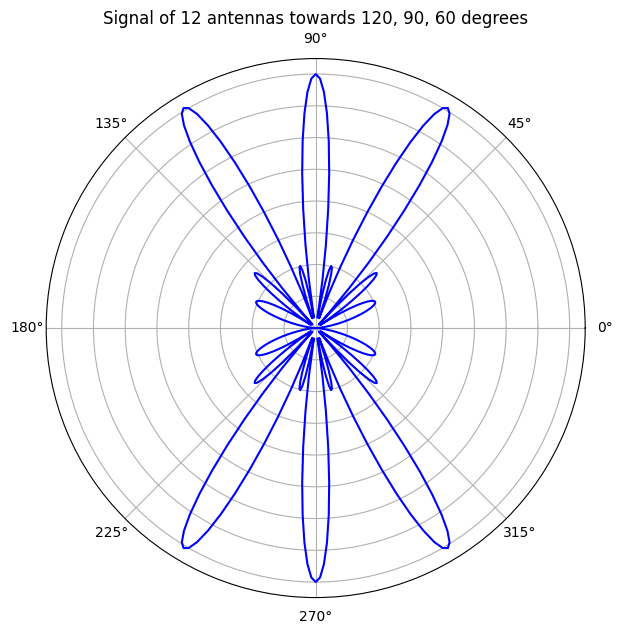

C:\Users\isakk\AppData\Local\Temp\ipykernel_8856\522842113.py:40: RuntimeWarning: divide by zero encountered in log10
  received_signal_dB = 10 * np.log10(received_signal_linear)


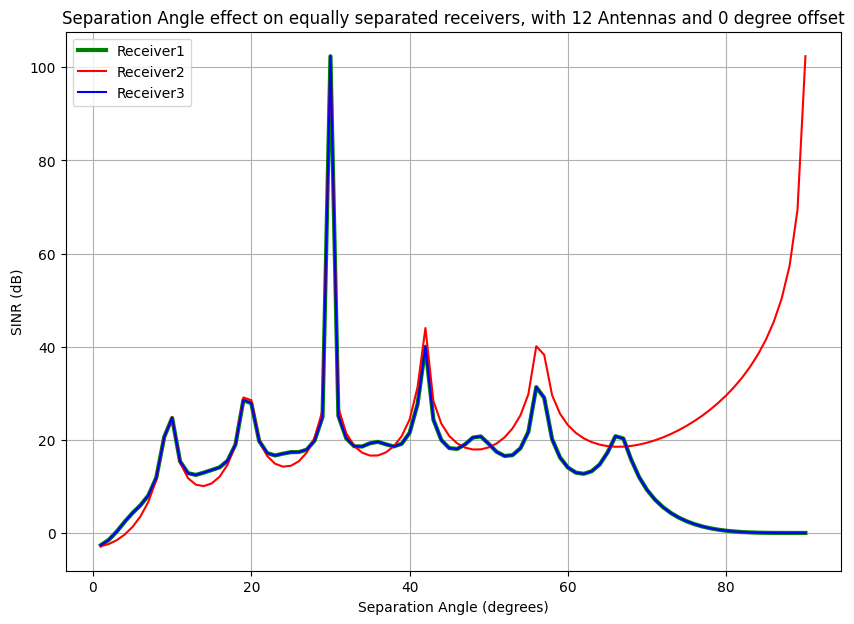

In [109]:
# First check for 3 receivers - the degree of separation effect [90-1 degree separation]
config3 = MIMOConfig(num_antennas=12, receiver_angles_deg=[120,90,60])
sp3 = superpose(config3.array_responses)
polarPlot(sp3, 'Signal of 12 antennas towards 120, 90, 60 degrees')

separation_angles = np.arange(90, 0, -1)  # Iterate from 90 to 1 degree of separation
antenna_counts = [12]  # Antenna configurations to test

separation_data = iterateOverAnglesAndAntennas(separation_angles, antenna_counts)
plt.figure(figsize=(10, 7))

plt.plot(separation_data["Separation_Angle"], separation_data["Receiver1"], label=f"Receiver1", color="green", linewidth=3)
plt.plot(separation_data["Separation_Angle"], separation_data["Receiver2"], label=f"Receiver2", color="red")
plt.plot(separation_data["Separation_Angle"], separation_data["Receiver3"], label=f"Receiver3", color="blue")

plt.title('Separation Angle effect on equally separated receivers, with 12 Antennas and 0 degree offset')
plt.xlabel('Separation Angle (degrees)')
plt.ylabel('SINR (dB)')
plt.legend()

plt.grid(True)
plt.show()


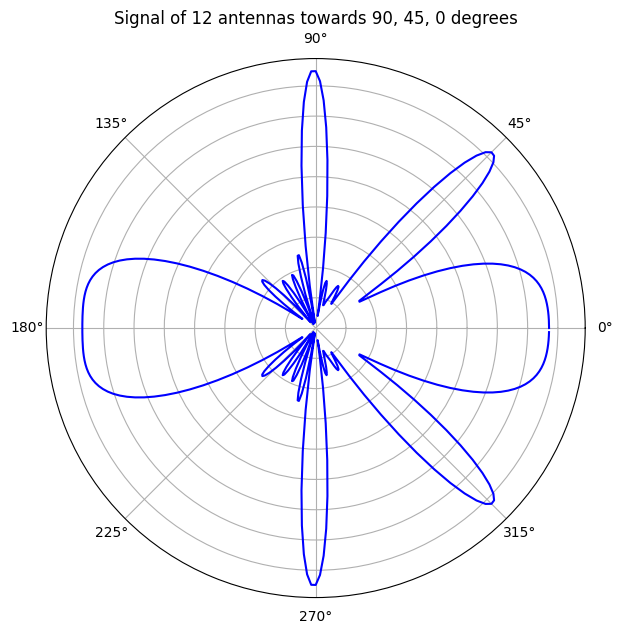

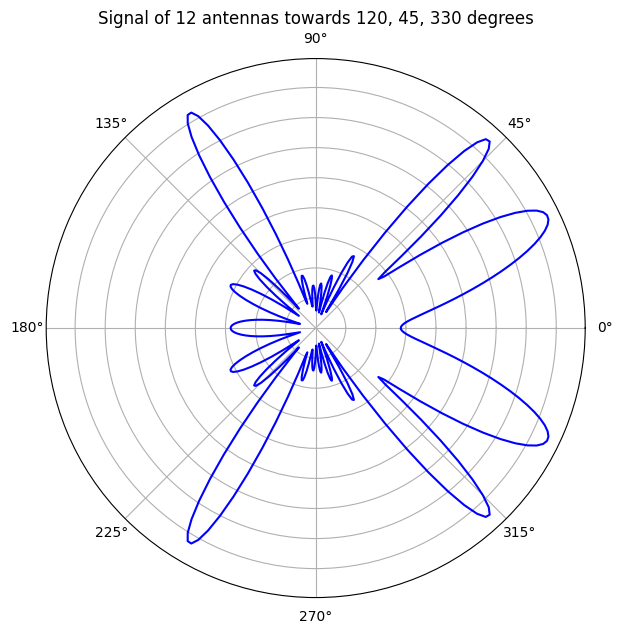

C:\Users\isakk\AppData\Local\Temp\ipykernel_8856\522842113.py:40: RuntimeWarning: divide by zero encountered in log10
  received_signal_dB = 10 * np.log10(received_signal_linear)


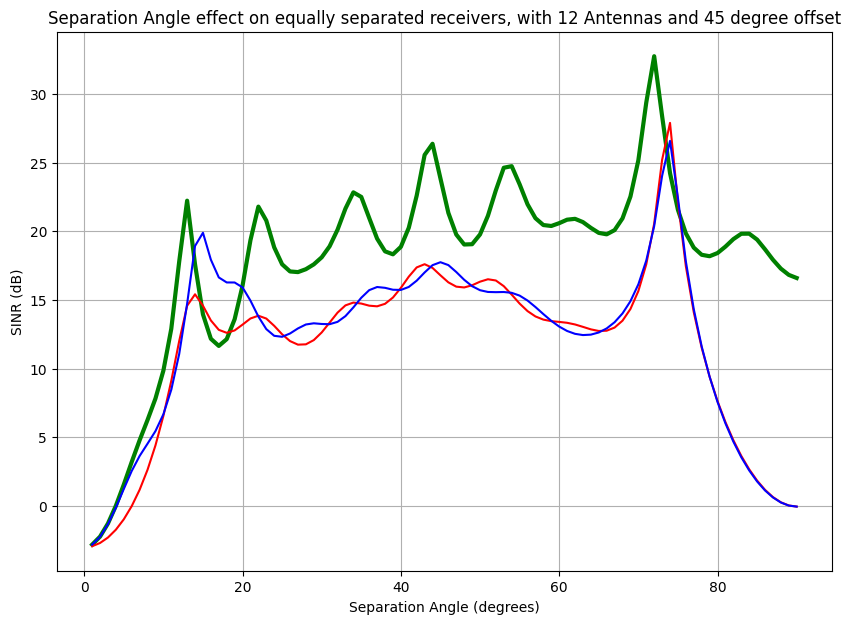

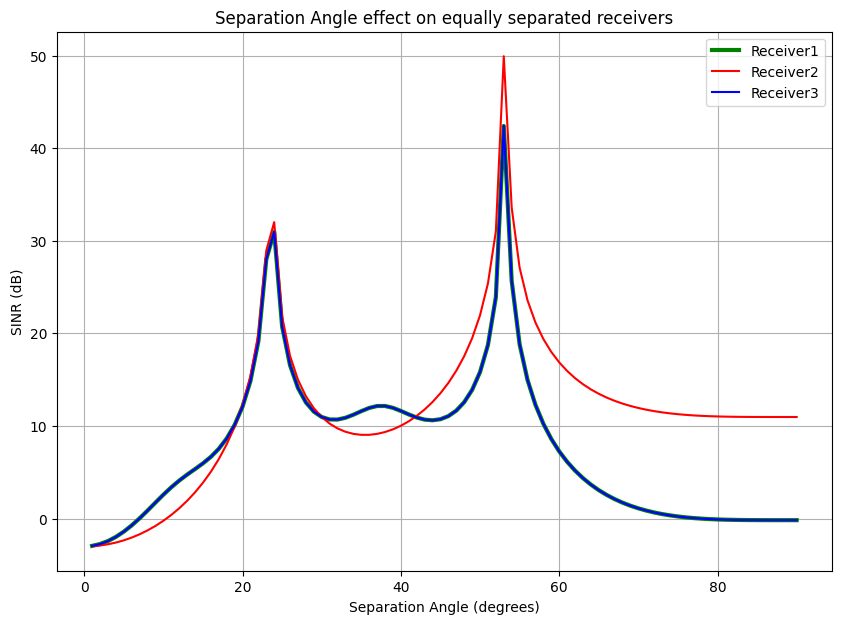

In [110]:


config3 = MIMOConfig(num_antennas=12, receiver_angles_deg=[90, 45, 0])
sp3 = superpose(config3.array_responses)
polarPlot(sp3, 'Signal of 12 antennas towards 90, 45, 0 degrees')

config3 = MIMOConfig(num_antennas=12, receiver_angles_deg=[120, 45, 330])
sp3 = superpose(config3.array_responses)
polarPlot(sp3, 'Signal of 12 antennas towards 120, 45, 330 degrees')


# First check for 3 receivers - the degree of separation effect [90-1 degree separation]
separation_angles = np.arange(90, 0, -1)  # Iterate from 90 to 1 degree of separation
antenna_counts = [12]  # Antenna configurations to test

separation_data = iterateOverAnglesAndAntennas(separation_angles, antenna_counts, 45)
plt.figure(figsize=(10, 7))

plt.plot(separation_data["Separation_Angle"], separation_data["Receiver1"], label=f"Receiver1", color="green", linewidth=3)
plt.plot(separation_data["Separation_Angle"], separation_data["Receiver2"], label=f"Receiver2", color="red")
plt.plot(separation_data["Separation_Angle"], separation_data["Receiver3"], label=f"Receiver3", color="blue")

plt.title('Separation Angle effect on equally separated receivers, with 12 Antennas and 45 degree offset')
plt.xlabel('Separation Angle (degrees)')
plt.ylabel('SINR (dB)')
plt.grid(True)
plt.show()





# First check for 3 receivers - the degree of separation effect [90-1 degree separation]
separation_angles = np.arange(90, 0, -1)  # Iterate from 90 to 1 degree of separation
antenna_counts = [5]  # Antenna configurations to test

separation_data = iterateOverAnglesAndAntennas(separation_angles, antenna_counts)
plt.figure(figsize=(10, 7))

plt.plot(separation_data["Separation_Angle"], separation_data["Receiver1"], label=f"Receiver1", color="green", linewidth=3)
plt.plot(separation_data["Separation_Angle"], separation_data["Receiver2"], label=f"Receiver2", color="red")
plt.plot(separation_data["Separation_Angle"], separation_data["Receiver3"], label=f"Receiver3", color="blue")

plt.title('Separation Angle effect on equally separated receivers')
plt.xlabel('Separation Angle (degrees)')
plt.ylabel('SINR (dB)')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\isakk\AppData\Local\Temp\ipykernel_8856\522842113.py:40: RuntimeWarning: divide by zero encountered in log10
  received_signal_dB = 10 * np.log10(received_signal_linear)


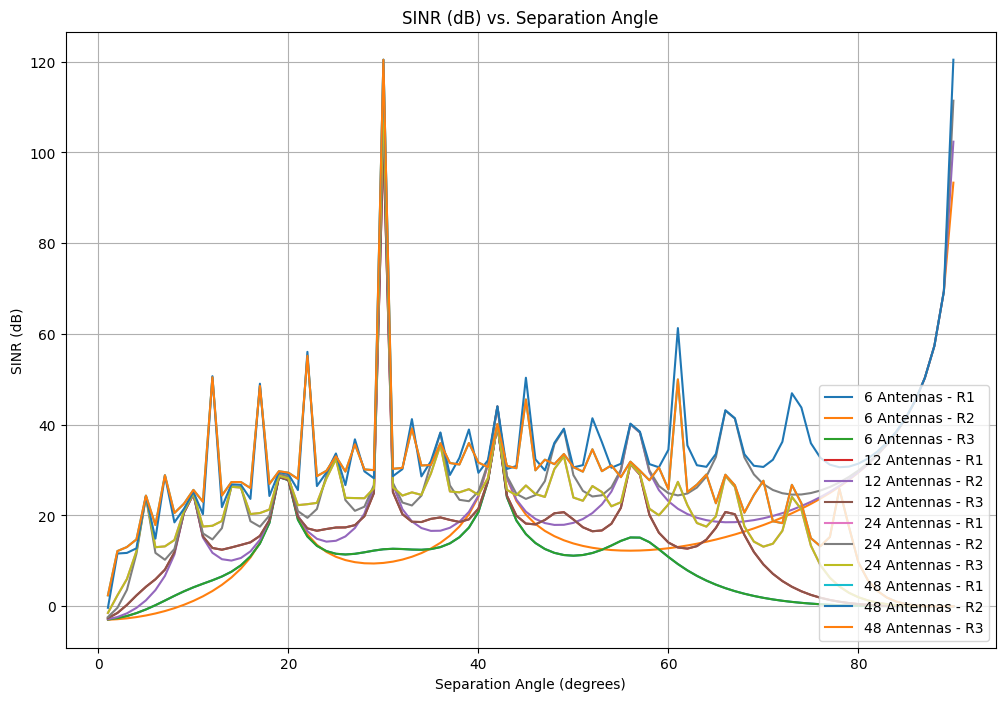

In [111]:
# Repeating the same scenario but increacing the number of antennas plotting them all 
antenna_counts = [6, 12, 24, 48]  # Antenna configurations to test
separation_variable_antenna_data = iterateOverAnglesAndAntennas(separation_angles, antenna_counts)
plt.figure(figsize=(12, 8))

for num_antennas in antenna_counts:
    #Filter data for the current number of antennas
    filtered_data = {key: [val[i] for i, antennas in enumerate(separation_variable_antenna_data["Antennas"]) if antennas == num_antennas] for key, val in separation_variable_antenna_data.items()}
    
    plt.plot(filtered_data["Separation_Angle"], filtered_data["Receiver1"], label=f"{num_antennas} Antennas - R1")
    plt.plot(filtered_data["Separation_Angle"], filtered_data["Receiver2"], label=f"{num_antennas} Antennas - R2")
    plt.plot(filtered_data["Separation_Angle"], filtered_data["Receiver3"], label=f"{num_antennas} Antennas - R3")

plt.title('SINR (dB) vs. Separation Angle')
plt.xlabel('Separation Angle (degrees)')
plt.ylabel('SINR (dB)')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

100  in DB 10.338285393426048  SINR:  24.885229309977177  and Shannon:  8.27137102518193
90  in DB 10.338785458154046  SINR:  24.896655730066897  and Shannon:  8.275154531024937
80  in DB 10.338285393426048  SINR:  24.88522930997718  and Shannon:  8.271371025181931


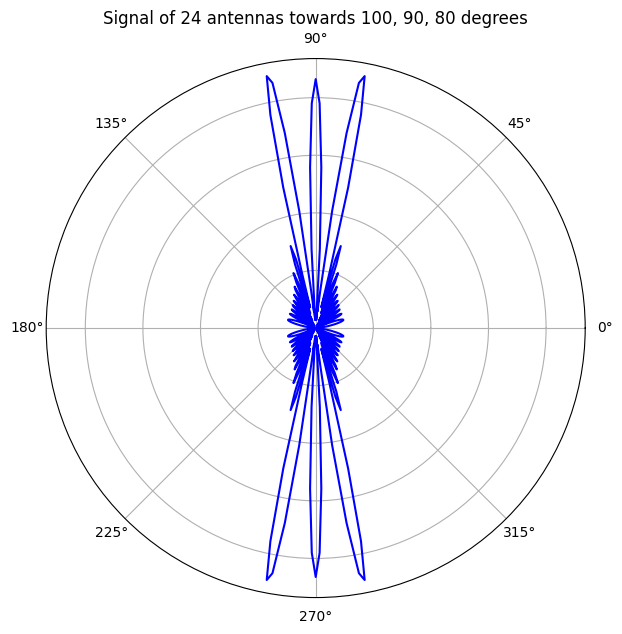

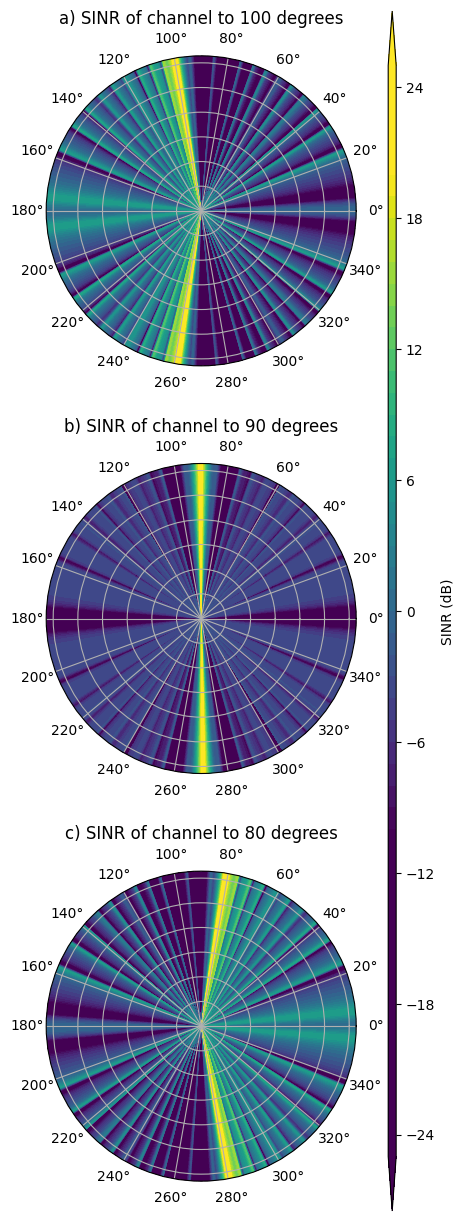

In [112]:


config4 = MIMOConfig(num_antennas=24, receiver_angles_deg=[100,90,80])
Recived_signal_arrays_dB = []
SINR_arrays_dB = []

#reciveds = receivedSignalAtAngle(config4, 2)
for i in range(3):
    reciveds = received_signal(config4, i, 0.1, -80)
    Recived_signal_arrays_dB.append(reciveds.get("Recived_signal_array_dB"))
    SINR_arrays_dB.append(reciveds.get("SINR_array_dB"))

    print(reciveds.get("Angle") ," in DB", reciveds.get("Received_signal_dB"), " SINR: ", reciveds.get("SINR_dB") , " and Shannon: ", reciveds.get("shannon"))


sp4 = superpose(config4.array_responses)
polarPlot(sp4, 'Signal of 24 antennas towards 100, 90, 80 degrees')



def plot_sinr_arrays(sinr_arrays, angles_deg, titles):

    # Create a polar plot
    fig, ax = plt.subplots(3, 1, subplot_kw={'projection': 'polar'}, figsize=(4, 15))

    # Convert angles to radians
    angles_rad = np.radians(angles_deg)
    #levels = np.arange(-10000, 100, 5)
    levels = np.arange(-25, 26, 1)

    cbar_ax = fig.add_axes([0.98, 0.1, 0.02, 0.8])  # Adjust these values for colorbar position

    for i, array in enumerate(sinr_arrays):
        axis = ax[i]  # Use 'i' as the index for the subplot
        # Plot the SINR array with custom color scale
        cax = axis.contourf(angles_rad, angles_rad, array, cmap=cm.viridis, levels=levels, vmin=-10, vmax=20, extend='both')
        axis.set_yticklabels([])

        # Set labels and title
        axis.set_title(titles[i])
        axis.set_xticks(np.linspace(0, 2 * np.pi, 18, endpoint=False))

    # Add colorbar
    cbar = fig.colorbar(cax, cax=cbar_ax)
    cbar.set_label('SINR (dB)')

    #fig.suptitle('SINR (dB) of signals with 24 antennas')


    plt.show()



angles_deg = np.linspace(0, 360, 360)
plot_sinr_arrays(SINR_arrays_dB, angles_deg, ['a) SINR of channel to 100 degrees','b) SINR of channel to 90 degrees','c) SINR of channel to 80 degrees'] )



From the figure ATH!, we can se a configuration of $M = 24$ antennas used to send separate channels to angles $\varphi = /{100, 90, 80/}$ or with an angular separation of 10 degrees. As the figure shows each channel has a highly directive $SINR$ to its desired angle $\varphi$ with an $SINR$ above 20dB. Where the signals do not seem to have any other un desired directions of strong signals other than the expected reflection over the x-axis, because of the linear antenna array configuration. 

C:\Users\isakk\AppData\Local\Temp\ipykernel_8856\522842113.py:40: RuntimeWarning: divide by zero encountered in log10
  received_signal_dB = 10 * np.log10(received_signal_linear)


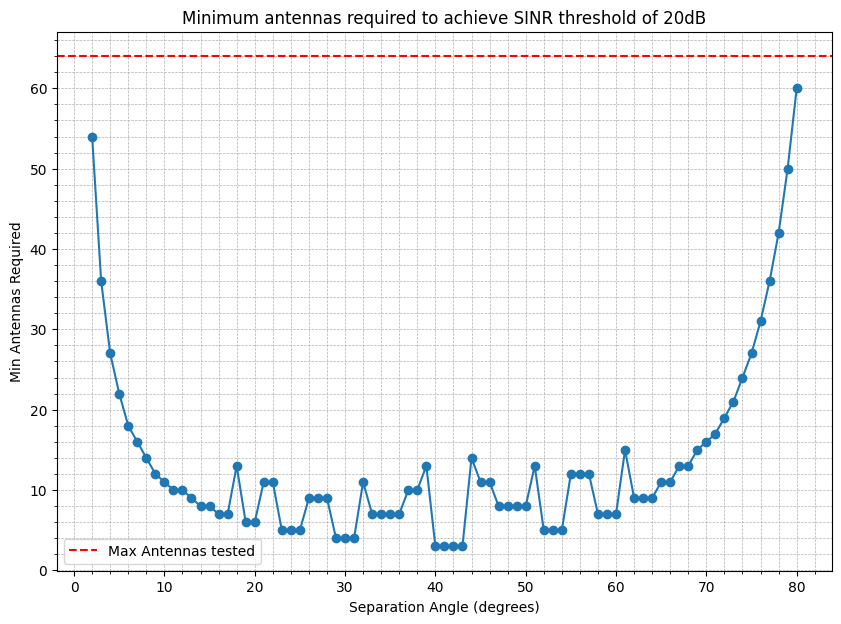

In [113]:
def simulate_and_plot_min_antennas_for_threshold(threshold_snr_dB, max_antennas, min_angle, max_angle, angle_step):
    TRANSMIT_POWER = 0.1   # in W
    NOISE_POWER = -80   # in dB
    centered_receiver_angle = 90

    separation_angles = np.arange(min_angle, max_angle + 1, angle_step)
    min_antennas_required = []

    for separation_angle in separation_angles:
        antennas_range = np.arange(1, max_antennas + 1)
        min_antennas_for_angle = float('inf')

        for antennas in antennas_range:
            config = MIMOConfig(num_antennas=antennas, receiver_angles_deg=[centered_receiver_angle + separation_angle, centered_receiver_angle, centered_receiver_angle - separation_angle])
            sinrs = [received_signal(config, i, TRANSMIT_POWER, NOISE_POWER).get("SINR_dB") for i in range(3)]

            # Check if all SINRs are above the threshold
            if all(sinr > threshold_snr_dB for sinr in sinrs):
                min_antennas_for_angle = antennas
                break  # No need to continue searching once the threshold is met for all receivers

        min_antennas_required.append(min_antennas_for_angle)
    
    plt.figure(figsize=(10, 7))
    # Plot the results with increased gridlines
    plt.plot(separation_angles, min_antennas_required, marker='o')
    plt.axhline(y=max_antennas, color='r', linestyle='--', label='Max Antennas tested')
    plt.xlabel('Separation Angle (degrees)')
    plt.ylabel('Min Antennas Required')
    plt.title('Minimum antennas required to achieve SINR threshold of 20dB')
    plt.legend()

    # Set minor locator for both axes
    plt.gca().xaxis.set_minor_locator(MultipleLocator(2))
    plt.gca().yaxis.set_minor_locator(MultipleLocator(2))

    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Example usage
simulate_and_plot_min_antennas_for_threshold(threshold_snr_dB=20, max_antennas=64, min_angle=1, max_angle=90, angle_step=1)
